In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('/content/final_df.csv')

In [6]:
df.head()

,location_name,year,month,sand,silt,clay,soc,ph,bdod,cec,ndvi,t2m_c,td2m_c,rh_pct,tp_m,ssrd_jm2,lc_type1
0,Alexandria,2017,1,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.23490,13.499527,6.782051,63.804614,0.317607,5.313632e+09,50
1,Alexandria,2017,2,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.25945,14.102349,7.990648,66.637249,0.114083,6.185134e+09,50
2,Alexandria,2017,3,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.26755,16.424418,9.963948,65.578252,0.074304,2.725764e+09,50
3,Alexandria,2017,4,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.23695,18.480010,11.995997,65.915311,0.056938,1.058778e+10,50
4,Alexandria,2017,5,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.22175,22.038071,15.278302,65.490480,0.030640,1.216407e+10,50


In [7]:
df.shape

(123999, 17)

In [8]:
# Drop longitude, latitude, POP
#df = df.drop(columns=['longitude', 'latitude', 'POP'])

In [9]:
# rename LC_Type1 : lc_type1, area : location_name
#df = df.rename(columns={'LC_Type1': 'lc_type1', 'area': 'location_name'})

In [10]:
# 2) Normalization function
def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min())

# Normalize available columns
variables = [
    "ndvi", "ssrd_jm2", "tp_m",
    "sand", "silt", "clay", "soc", "ph", "bdod", "cec",
    "t2m_c", "td2m_c", "rh_pct"
]

for v in variables:
    df[v + "_n"] = min_max_norm(df[v])

In [11]:
# 3) Compute pH stress
df["ph_stress"] = abs(df["ph"] - 7) / abs(df["ph"] - 7).max()

In [12]:
# 4) LC Type pressure
LC_map = {
    10: 0.2,
    20: 0.5,
    30: 0.4,
    40: 0.3,
    50: 0.7,
    60: 0.8,
    70: 0.6,
    90: 0.1
}
df["LC_pressure"] = df["lc_type1"].map(LC_map).fillna(0.5)

In [13]:
# 5) Vegetation Stress Index (VSI)
df["VSI"] = (
    0.6 * (1 - df["ndvi_n"]) +
    0.25 * (df["ssrd_jm2_n"]) +
    0.15 * (1 - df["tp_m_n"])
)

In [14]:
# 6) Soil Degradation Index (SDI)
df["SDI"] = (
    0.35 * df["sand_n"] +
    0.15 * df["clay_n"] +
    0.15 * (1 - df["soc_n"]) +
    0.15 * (1 - df["cec_n"]) +
    0.10 * df["bdod_n"] +
    0.10 * df["ph_stress"]
)

In [15]:
# 7) Climate Stress Index (CSI)
df["CSI"] = (
    0.45 * df["t2m_c_n"] +
    0.35 * df["ssrd_jm2_n"] +
    0.20 * (1 - df["rh_pct_n"])
)

In [16]:
# 8) Composite Desertification Index (DCI)
df["DCI"] = (
    0.40 * df["VSI"] +
    0.40 * df["SDI"] +
    0.20 * df["CSI"]
)

df["DCI_norm"] = min_max_norm(df["DCI"])

In [17]:
# 9) Classification thresholds
conditions = [
    (df["DCI_norm"] < 0.30),
    (df["DCI_norm"] >= 0.30) & (df["DCI_norm"] < 0.60),
    (df["DCI_norm"] >= 0.60)
]
labels = ["Low", "Medium", "High"]

df["des_level"] = np.select(conditions, labels, default='')

In [18]:
# Rule override: very low NDVI always High
df.loc[df["ndvi"] < 0.1, "des_level"] = "High"

In [19]:
df.head()

,location_name,year,month,sand,silt,clay,soc,ph,bdod,cec,...,td2m_c_n,rh_pct_n,ph_stress,LC_pressure,VSI,SDI,CSI,DCI,DCI_norm,des_level
0,Alexandria,2017,1,41.9,32.6,25.4,36.4,7.6,1.38,2.14,...,0.484840,0.823687,0.008,0.7,0.601645,0.301743,0.278884,0.417132,0.236233,Low
1,Alexandria,2017,2,41.9,32.6,25.4,36.4,7.6,1.38,2.14,...,0.523767,0.868795,0.008,0.7,0.624220,0.301743,0.301909,0.430767,0.259508,Low
2,Alexandria,2017,3,41.9,32.6,25.4,36.4,7.6,1.38,2.14,...,0.587324,0.851931,0.008,0.7,0.557291,0.301743,0.246371,0.392888,0.194848,Low
3,Alexandria,2017,4,41.9,32.6,25.4,36.4,7.6,1.38,2.14,...,0.652774,0.857298,0.008,0.7,0.727670,0.301743,0.485394,0.508844,0.392787,Medium
4,Alexandria,2017,5,41.9,32.6,25.4,36.4,7.6,1.38,2.14,...,0.758492,0.850533,0.008,0.7,0.769594,0.301743,0.580453,0.544625,0.453866,Medium


In [20]:
df[["location_name","year","month","des_level"]].head()

,location_name,year,month,des_level
0,Alexandria,2017,1,Low
1,Alexandria,2017,2,Low
2,Alexandria,2017,3,Low
3,Alexandria,2017,4,Medium
4,Alexandria,2017,5,Medium


In [21]:
df.sample().T

,111397
location_name,Fayoum
year,2024
month,11
sand,559.0
silt,195.0
clay,247.0
soc,163.0
ph,80.0
bdod,131.0
cec,192.0


In [22]:
def plot_degradation_line(df, location):
    data = df[df['location_name'] == location].sort_values(['year', 'month'])

    plt.figure(figsize=(12,6))
    plt.plot(data['month'], data['VSI'], label='VSI')
    plt.plot(data['month'], data['SDI'], label='SDI')
    plt.plot(data['month'], data['CSI'], label='CSI')
    plt.plot(data['month'], data['DCI'], label='DCI')

    plt.title(f'Degradation Index Trend – {location}')
    plt.xlabel('Month')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
def plot_seasonal_risk(df, location):
    data = df[df['location_name'] == location]

    plt.figure(figsize=(10,5))
    sns.lineplot(x="month", y="DCI_norm", data=data, marker="o")

    plt.title(f"Seasonal Desertification Risk – {location}")
    plt.xlabel("Month")
    plt.ylabel("Normalized Desertification Risk (DCI_norm)")
    plt.grid(True)
    plt.show()

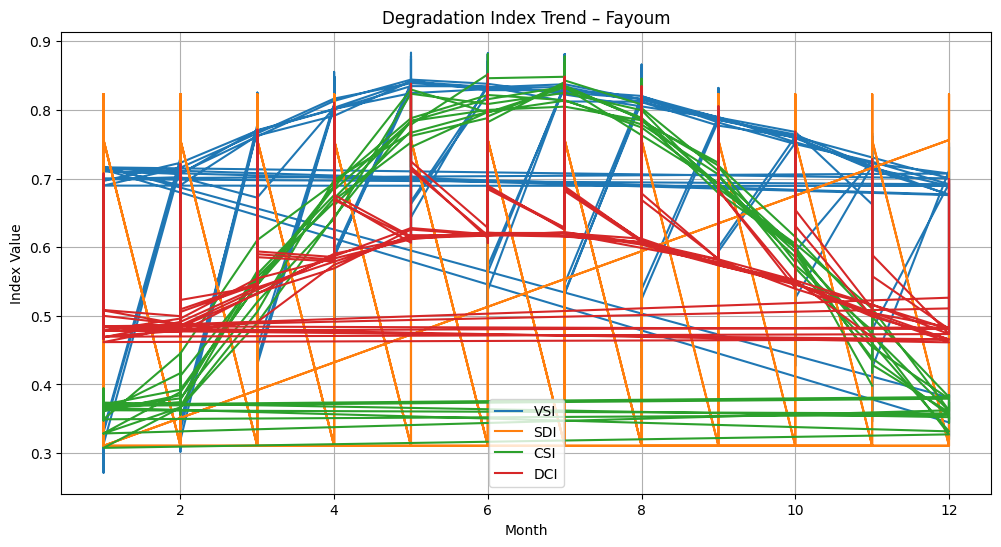

In [24]:
plot_degradation_line(df, "Fayoum")

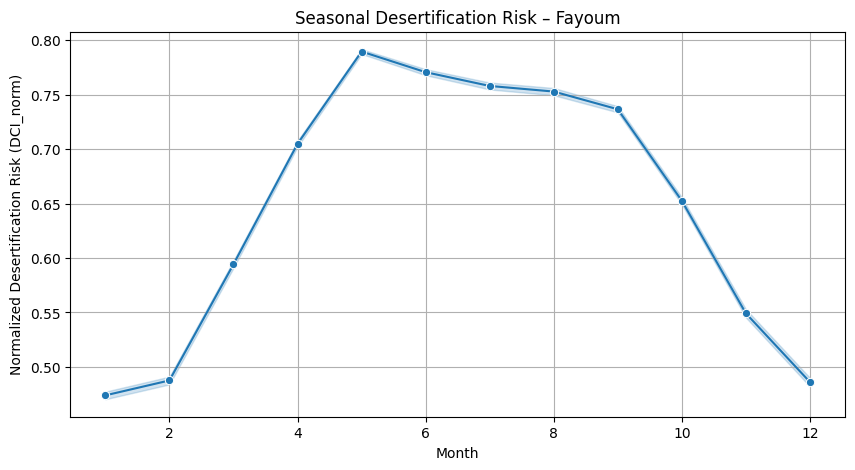

In [25]:
plot_seasonal_risk(df, "Fayoum")

In [26]:
df['des_level'].value_counts()

,count
des_level,
High,65647
Medium,54571
Low,3781


In [27]:
# drop Desertification indicies
df = df.drop(columns=['VSI', 'SDI', 'CSI', 'DCI', 'DCI_norm'])

In [32]:
df.sample()

,location_name,year,month,sand,silt,clay,soc,ph,bdod,cec,...,soc_n,ph_n,bdod_n,cec_n,t2m_c_n,td2m_c_n,rh_pct_n,ph_stress,LC_pressure,des_level
104841,Fayoum,2024,4,530.0,205.0,266.0,315.0,77.0,130.0,189.0,...,0.381115,0.933244,0.865628,0.587139,0.603343,0.500113,0.335745,0.933333,0.3,High


In [29]:
derived_cols = [
    'VSI', 'SDI', 'CSI', 'DCI', 'DCI_norm',
    'ph_stress', 'LC_pressure'
]

cols_to_drop = [col for col in df.columns if col.endswith('_n')] + derived_cols

df_clean = df.drop(columns=cols_to_drop, errors='ignore')

print("Dropped:", cols_to_drop)

Dropped: ['ndvi_n', 'ssrd_jm2_n', 'tp_m_n', 'sand_n', 'silt_n', 'clay_n', 'soc_n', 'ph_n', 'bdod_n', 'cec_n', 't2m_c_n', 'td2m_c_n', 'rh_pct_n', 'VSI', 'SDI', 'CSI', 'DCI', 'DCI_norm', 'ph_stress', 'LC_pressure']


In [30]:
df_clean.columns.to_list()

['location_name',
 'year',
 'month',
 'sand',
 'silt',
 'clay',
 'soc',
 'ph',
 'bdod',
 'cec',
 'ndvi',
 't2m_c',
 'td2m_c',
 'rh_pct',
 'tp_m',
 'ssrd_jm2',
 'lc_type1',
 'des_level']

In [31]:
df_clean.to_csv("desertification_labeled.csv", index=False)